**Segmentation based on morphogenie**

http://morphogenie.fr/segmenting-nuclei.html

At this point I would like to try running this code with a stack containing multiple nuclei.
MMstack.ome.tif files load in a different order c,z,x,y.
They could be opened and saved first using bio-formats importer.

v5.2 - I am now trying to detect nuclei by fitting polygons (openCV), to simply analysis of uneven staining

v5.3 - Focus on trying to reach an endpoint.
     - opencv installed

In [1]:
import skimage.io as io
io.use_plugin('tifffile')

#I updated "skimage.filter" to the more recent plural "skimage.filters"
from skimage.filters import threshold_otsu, threshold_adaptive, rank
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage.morphology import disk, watershed
import pandas as pd
import numpy as np #added to morphogenie code
import mahotas as mh  #used for labelling binary regions
import matplotlib.pyplot as plt #added to morphogenie code
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import distance as dist
import scipy.cluster.hierarchy as hier
from scipy import fftpack
from matplotlib.colors import LogNorm
import math
import cv2 as cv
import numpy.ma as MA ##Try working with a masked array
from skimage.morphology import watershed
from skimage.segmentation import clear_border
from scipy.ndimage import morphology
import skimage.morphology

In [2]:
%matplotlib inline

In [ ]:
##Assumptions

#Nuclei cannot be thinner than 2.6um == 10 z slices
#Narrower than 3um == 46 pixels
#Or wider than 20um == 308 pixels

#They cannot be dimmer than background
#Transfected nuclei cannot be dimmer than GFP_background

In [7]:
import skimage.io as io
io.use_plugin('tifffile')

#I adjusted the morphogenie code to import the full stack, and then focus on the Hoechst Channel for segmentation.
#im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_2_Box1.tif')

#im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1_MMStack_Pos0.ome.tif')

im = io.imread('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Well02_HeLa_PHD2-IDR-PHD3_1/Well02_HeLa_PHD2-IDR-PHD3_1.tif')

Hoechst_stack = im[:,:,:,0]

z_size, x_size, y_size = Hoechst_stack.shape

z_scale = 0.26 # µm per plane for 100x NIC confocal images
xy_scale = 0.065 # µm per pixel for 100x NIC confocal images

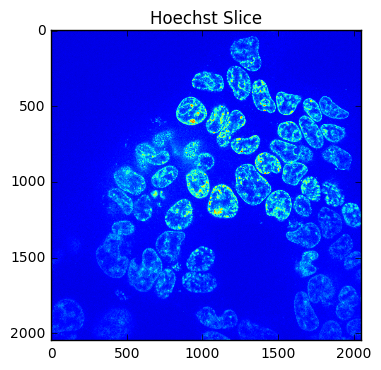

In [4]:
##Quick check
#image_stack = im[0,:,:,:] #for .ome.tif files
#image_stack.shape
plt.imshow(Hoechst_stack[4])
plt.title('Hoechst Slice')

In [ ]:
##Find seeds
test = mh.gaussian_filter(Hoechst_stack[4], 5.)
rmax = mh.regmax(test)

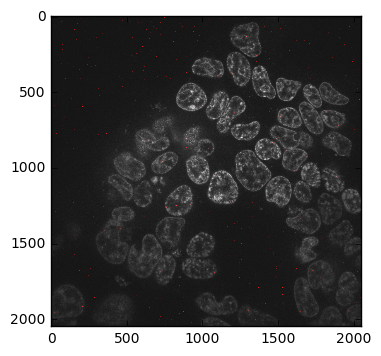

In [14]:
plt.imshow(mh.overlay(Hoechst_stack[4], rmax))
#plt.imshow(rmax, cmap='gray')

**Find transfected cells**

Q: What is the background GFP intensity?

A: ~120

Q: What is the background Hoechst intensity?

A: ~110

Q: Where are the transfected cells?

A: Transfected cells fall within the filled_course_GFP_mask


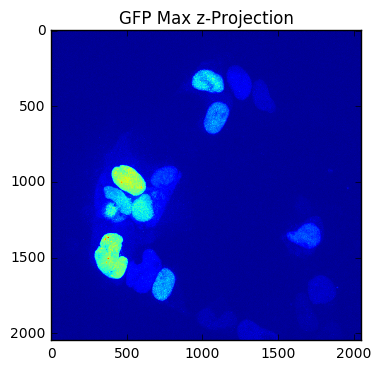

In [15]:
GFP_stack=im[:,:,:,1]
MAX_GFP=GFP_stack.max(axis=0)
plt.imshow(MAX_GFP)
plt.title('GFP Max z-Projection')

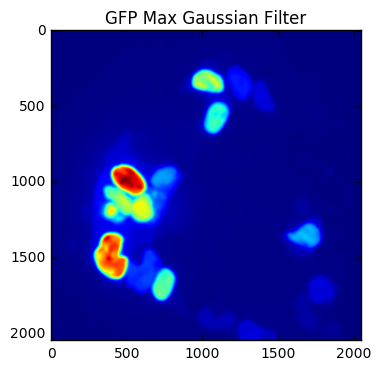

In [16]:
#Smooth signal
course_GFP = mh.gaussian_filter(MAX_GFP, 10.)
plt.imshow(course_GFP)
plt.title('GFP Max Gaussian Filter')

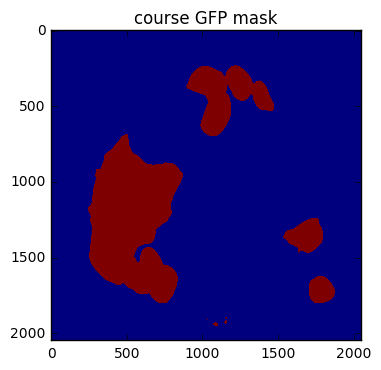

In [17]:
##Threshold
course_GFP_mean = course_GFP.mean()
course_GFP_mask = course_GFP > course_GFP_mean

##Remove cells on the border
cleared_course_GFP_mask = clear_border(course_GFP_mask).astype(int)

##Fill holes
filled_course_GFP_mask = np.array(morphology.binary_fill_holes(cleared_course_GFP_mask).astype(int))

plt.imshow(filled_course_GFP_mask)
plt.title('course GFP mask')

**Detect Nuclei**

In [23]:
##Need to broadcast the 1d mask (here using 'ones_like', to mask the 3D Hoechst stack
##Use np.logical_not to invert, ~ gives integer inversion resulting in -1s.
GFP3d_mask=np.ones_like(Hoechst_stack)*np.logical_not(filled_course_GFP_mask)

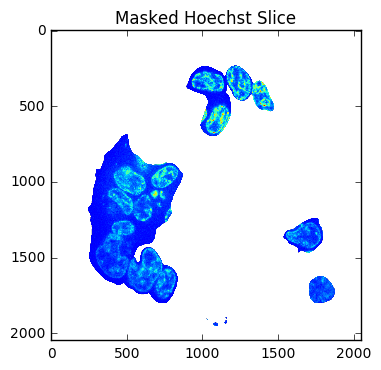

In [24]:
##Mask Hoechst image to focus on transfected nuclei
Hoechst_ma=MA.masked_array(Hoechst_stack,
                           mask=GFP3d_mask, 
                           fill_value=0.)

plt.imshow(Hoechst_ma[4])
plt.title('Masked Hoechst Slice')

In [24]:
##Find Nuclei

##3D Gaussian Filter
#I tried using the mask, but it was completely ignored by the gaussian filter
smoothed_Hoechst_stack=mh.gaussian_filter(Hoechst_stack, 2.)
shs_mean = smoothed_Hoechst_stack.mean()
Hoechst_mask = smoothed_Hoechst_stack > shs_mean

##Clear border and Fill holes ineffective on 3D stacks

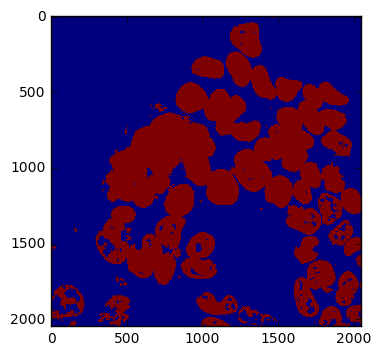

In [115]:
plt.imshow(Hoechst_mask[4])

In [28]:
##Determine the best filter (SLOW!!)
f_mask=[]
for s in range(2,22,2):
    fs = mh.gaussian_filter(Hoechst_stack, s)
    fs_true = fs > fs.mean()
    f_mask.append(fs_true) #an array of 10 3d stacks

(-0.5, 2047.5, 2047.5, -0.5)

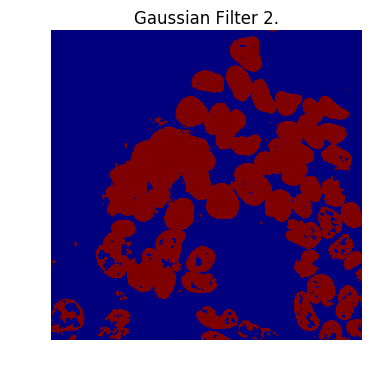

In [168]:
plt.imshow(f_mask[0][4])
plt.title('Gaussian Filter 2.')
plt.axis('off')

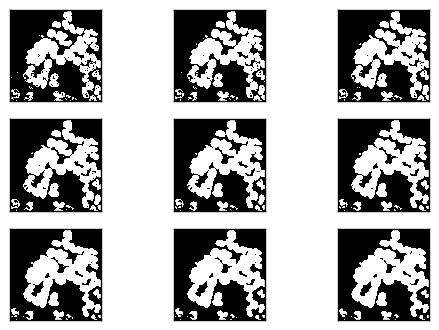

In [38]:
#Plot Range
for i in xrange(9):
    plt.subplot(3,3,i+1),plt.imshow(f_mask[i][4],'gray')
    #plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

**Fill Holes**

In [47]:
f_mask[0].shape

(24L, 2048L, 2048L)

In [142]:
## Process binary array frame by frame:
def fill_3D(array):
    stack=np.zeros_like(array)
    for z, frame in enumerate(array):
        filled = morphology.binary_fill_holes(frame).astype(int)
        stack[z] = filled
    return stack

#plt.imshow(stack[4])

In [143]:
filled=fill_3D(Hoechst_mask)

In [135]:
##Remove small
min_vol = 50000
max_vol = 1000000

#from skimage.morphology import remove_small_objects
real_nuclei=skimage.morphology.remove_small_objects(filled, min_vol)

In [105]:
##Nuclear_max using (3, 25, 25) max filter
Nu_max=ndimage.maximum_filter(Hoechst_stack, footprint=np.ones((3, 25, 25)))

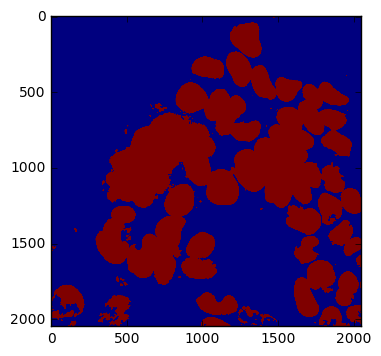

In [144]:
plt.imshow(filled[4])

In [148]:
##calculate distance image
distance=morphology.distance_transform_edt(filled)

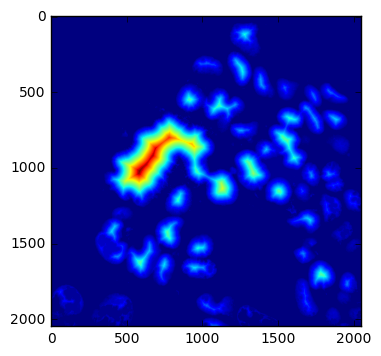

In [150]:
plt.imshow(distance[11])

In [157]:
##local_distance_maxima
d_max_filt=ndimage.maximum_filter(distance, footprint=np.ones((3, 25, 25)))

#local max distance pixels
d_max=distance==d_max_filt

#Remove background
Nu_d_max=d_max*filled

In [108]:
#Local max pixels
mark=Hoechst_stack==Nu_max

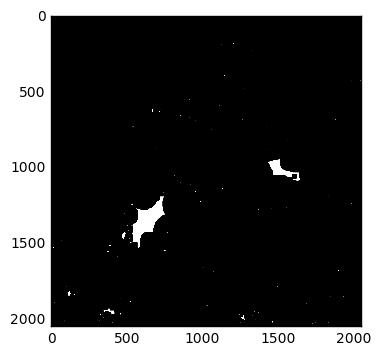

In [158]:
plt.imshow(Nu_d_max.max(axis=0), cmap='gray')
#plt.imshow(mh.overlay(Hoechst_stack.max(axis=0),mark.max(axis=0)))

In [163]:
##Erode to single pixel

#Label
labeled_d_max, nr_objects = mh.label(Nu_d_max)
nr_objects

900L

In [167]:
#Get centroid
d_max_props=regionprops(labeled_d_max[4])
d_max_props[].centroid

AttributeError: 'list' object has no attribute 'centroid'

In [161]:
##Calculate watershed
#ws must be performed 1 slice at a time as most nuclei are connected across all 24 slices
ws=watershed(distance[5],Nu_d_max[5])

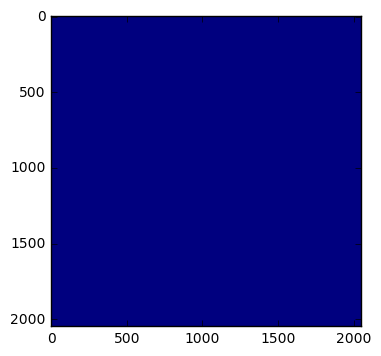

In [162]:
plt.imshow(ws)

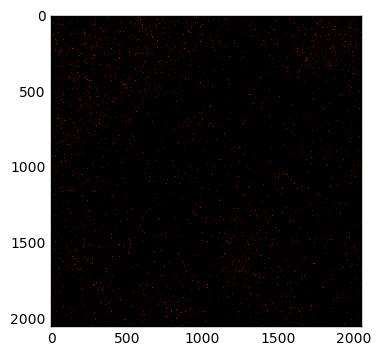

In [130]:
#plt.imshow(distance[4])
plt.imshow(mh.overlay(ws.max(axis=0),mark.max(axis=0)))

In [78]:
##Erode with diamond
def derode(array, iterations):
   
    for i in range(iterations):
        array=morphology.binary_erosion(array, skimage.morphology.diamond(3))
        array=morphology.binary_opening(array) ##Useless even at high iterations
        array=morphology.binary_dilation(array)
    return array

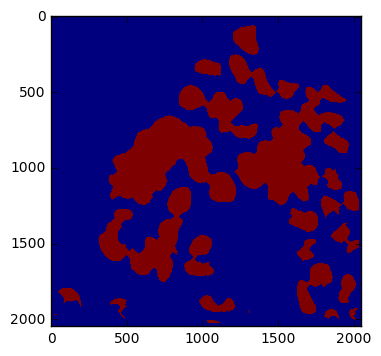

In [80]:
seed=derode(filled,10)
plt.imshow(seed)

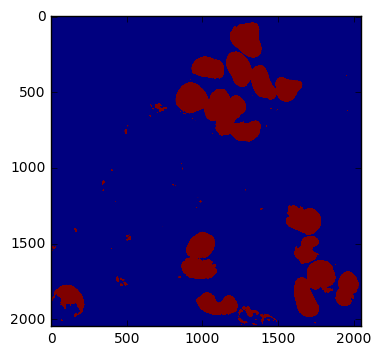

In [40]:
plt.imshow(clear_fill(f_mask[0])[4]) ##Most nuclei are connected and touch the edge

In [30]:
##v5.2 - Try max filter right off the bat

##Tight_smooth using (3, 5, 5) median filter
tight_smooth=ndimage.max_filter(Hoechst_stack, footprint=np.ones((3, 5, 5)))

##Mask Hoechst image to focus on transfected nuclei
tight_ma=MA.masked_array(tight_smooth,
                         mask=GFP3d_mask,
                         fill_value=0.)
                           
#Calculate threshold for tight smooth nuclei 'tT'         
tT=tight_ma.mean()

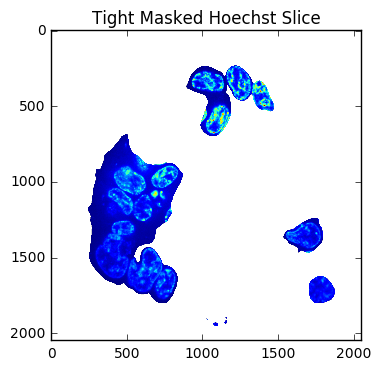

In [31]:
plt.imshow(tight_ma[4])
plt.title('Tight Masked Hoechst Slice')

In [35]:
##Generate tight smooth mask
#clustered_nuclei=tight_smooth>250
nuclei_stack=tight_smooth>tT

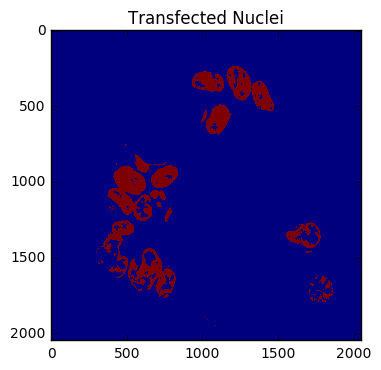

In [36]:
##Intersect Hoechst and GFP binary masks to identify transfected cells
transfected_nuclei=nuclei_stack*np.logical_not(GFP3d_mask)

plt.imshow(transfected_nuclei[4])
plt.title('Transfected Nuclei')

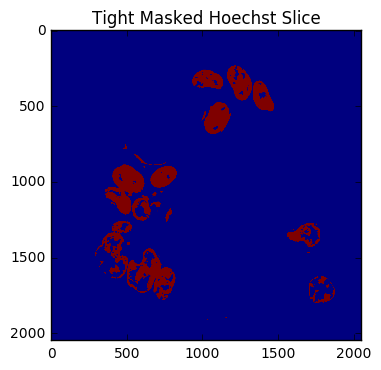

In [37]:
plt.imshow(transfected_nuclei[10])
plt.title('Tight Masked Hoechst Slice')

In [27]:
##Try with tight_ma

nuclei_stack = np.zeros_like(Hoechst_mask)

## Labeling for each z plane:
for z, frame in enumerate(transfected_nuclei):
    cleared_H = clear_border(frame).astype(int)
    filled_H = morphology.binary_fill_holes(cleared_H).astype(int)
    nuclei_stack[z] = filled_H

NameError: name 'transfected_nuclei' is not defined

In [ ]:
##Plot Detected Nuclei
plt.imshow(nuclei_stack[0])
plt.title('Detected Nuclei')

In [ ]:
##Intersect Hoechst and GFP binary masks to identify transfected cells
transfected_nuclei=nuclei_stack*np.logical_not(GFP3d_mask)

plt.imshow(transfected_nuclei[4])
plt.title('Transfected Nuclei')

In [ ]:
##Try labelling first
#Labelling works with 3D arrays, so connectivity is already estabilshed
labeled_nuclei, nr_objects = mh.label(transfected_nuclei)
labeled_nuclei
plt.imshow(labeled_nuclei[4])

In [ ]:
#3D bounding boxes
bb  = np.array(nuc_props[1].bbox)
#zmin, ymin, xmin, zmax, ymax, xmax  = nuc_props[1].bbox
#zmin, ymin, xmin, zmax, ymax, xmax = bb
crp=labeled_nuclei[bb[0]:bb[3],bb[1]:bb[4],bb[2]:bb[5]]
#plt.imshow(labeled_nuclei[zmin:zmax,ymin:ymax,xmin:xmax])
plt.imshow(crp[1]) #Remember the image is still 3D



In [ ]:
#Area in each plane
bb[0], bb[3] #object 1 covers 25 planes (more than there actually are?? because Python is inclusive->exclusive

In [ ]:
#np.count_nonzero(crp[0]) #area in frame0 = 26,693
#np.count_nonzero(crp[1]) #area in frame1 = 26,629
#np.count_nonzero(crp[23]) #area in frame0 = 17,469

#nuc_props[1].area #area given for frame1 = 561,595, which suggests "area" is acctually volume == total pixels
nuc1=labeled_nuclei==2
sum(sum(sum(nuc1))) # gives the same figure, 561,595

In [ ]:
#Watershed nuclei above the upper limit
props=[]
indx=[]

nuc_props=regionprops(label_image=labeled_nuclei, intensity_image=GFP_stack) #18 object labelled

heading=["volume","mean_GFP","integrated_GFP"]

for n in nuc_props:
    props.append([n.area,
                  n.mean_intensity,
                  n.mean_intensity * n.area])
    indx.append(n.label)
Nuclear_Properties=pd.DataFrame(props, index=indx, columns=heading)
Nuclear_Properties

**Detection parameters**

We usually need some settings, derived from what we now of the objects we are trying to segment. 
We’ll also normaly do some kind of smoothing, which will be specified as the pixel size of the filter kernel. So here we go:

In [ ]:
min_vol = 50000
max_vol = 1000000

#from skimage.morphology import remove_small_objects
real_nuclei=remove_small_objects(labeled_nuclei, min_vol)

In [ ]:
plt.imshow(real_nuclei[4])

In [ ]:
clusters=remove_small_objects(labeled_nuclei, max_vol)
plt.imshow(clusters[4])

In [ ]:
##Tight_smooth using (3, 5, 5) median filter
tight_smooth=ndimage.median_filter(Hoechst_stack, footprint=np.ones((3, 5, 5)))

##Mask Hoechst image to focus on transfected nuclei
clusters_ma=MA.masked_array(tight_smooth,                       
                           mask=np.logical_not(clusters), 
                           fill_value=0.)

#Calculate threshold for clustered nuclei 'cT'         
cT=clusters_ma.mean()

In [ ]:
##Generate tight smooth mask
#clustered_nuclei=tight_smooth>250
clustered_nuclei=tight_smooth>cT

In [ ]:
##Plot result
plt.imshow(clustered_nuclei[4])
plt.title('Tight Smooth Mask')

In [64]:
##Try fitting polygon
img8 = (MAX_GFP).astype('uint8')
#thresh=cv2.threshold(img8,100,255, 0)
blur = cv2.GaussianBlur(img8,(7,7),0)
ret,thresh = cv2.threshold(blur, 0, 225, cv2.THRESH_OTSU)
#contours,hierarchy = cv2.findContours(thresh, 1, 2)
im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#contours,hierarchy = cv2.findContours(filled_course_GFP_mask, 1, 2)

# Otsu's thresholding after Gaussian filtering
#blur = cv2.GaussianBlur(img8,(5,5),0)
#ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#plt.imshow(th3)

In [66]:
hierarchy

array([[[  1,  -1,  -1,  -1],
        [  2,   0,  -1,  -1],
        [  3,   1,  -1,  -1],
        ..., 
        [317, 315,  -1, 314],
        [318, 316,  -1, 314],
        [ -1, 317,  -1, 314]]])

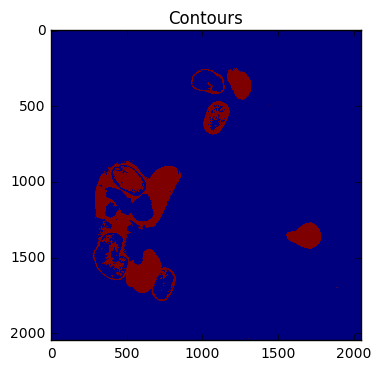

In [77]:
plt.imshow(im2)
plt.title('Contours')

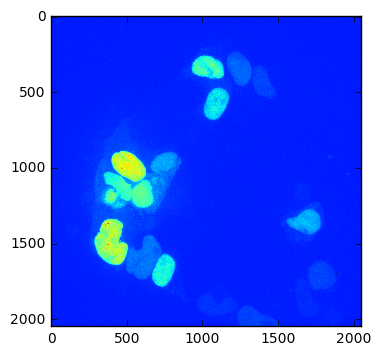

In [74]:
cnt = contours[2]
#plt.imshow(cv2.drawContours(MAX_GFP, [cnt], 0, (0,255,0), 3))
cv2.drawContours(MAX_GFP, [cnt], 0, (0,255,0), 3)
plt.imshow(MAX_GFP)

In [76]:
MAX_GFP.max()

725

In [39]:
##This is the function that clears objects from the image border and fills holes slice by slice.
def clear_fill(array):
    '''Loops through each slice of an array, removes objects from edges and fills holes`.
    
    Parameters:
    -----------
    array: a bloolean array
        
    Returns:
    --------
    
    values: 'stack', an array with the same shape as `array`
        
    '''
    stack = np.zeros_like(array)

    ## Process binary array frame by frame:
    for z, frame in enumerate(array):
        cleared = clear_border(frame).astype(int)
        c = skimage.morphology.closing(cleared)
        cc = skimage.morphology.closing(c)
        filled = morphology.binary_fill_holes(cc).astype(int)
        o = skimage.morphology.opening(filled)
        oo = skimage.morphology.opening(o)
        stack[z] = oo

    return stack

In [356]:
##Call clear_fill function
filled_clusters=clear_fill(clustered_nuclei)

##Relabel
new_labeled_nuclei, nr_objects = mh.label(filled_clusters)

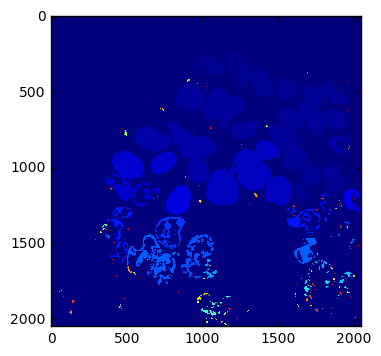

In [343]:
plt.imshow(new_labeled_nuclei[10])

In [357]:
##Intersect Hoechst and GFP binary masks to identify transfected cells
bw=clusters>0
#Use <0 to remove original labels from 'clusters', converting to a binary image
transfected_clusters=new_labeled_nuclei*bw

##Filter by size
real_clustered_nuclei=remove_small_objects(transfected_clusters, min_vol) #After fill

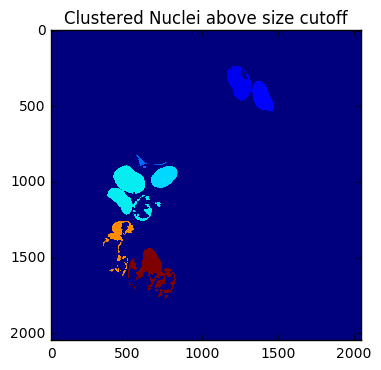

In [368]:
plt.imshow(real_clustered_nuclei[6])
plt.title('Clustered Nuclei above size cutoff')

In [ ]:
##Filter by size


**Watershed**

In [ ]:
##Test case
distance = ndimage.distance_transform_edt(clusters[4])
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)), labels=clusters[4])
markers = ndimage.label(local_maxi)[0]
labeled_clusters = watershed(-distance, markers, mask=clusters[4])

In [ ]:
##Alternaive using GFP intensity
distance = ndimage.distance_transform_edt(clusters[4])
local_maxi = peak_local_max(GFP_stack[4], indices=False, footprint=np.ones((40, 40)), labels=clusters[4]) ##Using GFP data
markers = ndimage.label(local_maxi)[0]
labeled_clusters = watershed(-distance, markers, mask=clusters[4])

In [ ]:
##Test case
distance = ndimage.distance_transform_edt(clusters[4])
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((10, 10)), labels=clusters[4])
markers = ndimage.label(local_maxi)[0]
labeled_clusters = watershed(-distance, markers, mask=clusters[4])

In [ ]:
##Show the output
plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(clusters[4], cmap='gray', interpolation='nearest')
plt.axis('off')
plt.subplot(132)
plt.imshow(-distance, interpolation='nearest')
plt.axis('off')
plt.subplot(133)
plt.imshow(labeled_clusters, cmap='spectral', interpolation='nearest')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)
plt.show()

In [ ]:
#3D watershed has issues with ambiguity it connectivity array
#ws_stack = np.zeros_like(full_mask_stack)
## Watershed all planes
#distance = ndimage.distance_transform_edt(full_mask_stack)
#local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((1, 5, 5)))
#markers = ndimage.label(local_maxi)[0]
#ws_stack = watershed(-distance, markers, full_mask_stack)

In [ ]:
#Process stack
ws_stack = np.zeros_like(full_mask_stack)
## Watershed each z plane:
for z, frame in enumerate(full_mask_stack):
    distance = ndimage.distance_transform_edt(frame)
    local_maxi = peak_local_max(
        distance, indices=False, footprint=np.ones((20, 20)), labels=frame)
    markers = ndimage.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=frame)

    ws_stack[z] = labels

**Select Objects**

In [ ]:
##Check the filtered stack
nrows = np.int(np.ceil(np.sqrt(z_size)))
ncols = np.int(z_size // nrows + 1)

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
for n in range(z_size):
    i = n // ncols
    j = n % ncols
    axes[i, j].imshow(ws_stack[n, ...],
                      interpolation='nearest', cmap='gray')
    
    
## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)
fig.tight_layout()

In [ ]:
##'approximate_polygon' may be a simple way to simplify and smooth the detected objects.

contours, hierarchy = cv2.findContours(binaryimage,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

for ind, cont in enumerate(contours):
    elps = cv2.fitEllipse(cont)
    #Feed elps directly into cv2.ellipse
    cv2.ellipse(displayframe,elps,(0,0,255))

cv2.imshow("Perfectly fitted ellipses", displayframe)

**Computing the properties of the labeled regions:**

We use skimage.measure handy function regionprops. For convinience, we store the computed properties in a pandas DataFrame object (this is particullarly usefulll if you have more images or more timepoints, and want to later on manipulate the collected data.

In [ ]:
labeled_stack=ws_stack

properties = []
columns = ('x', 'y', 'z', 'I', 'w')                 #could be cleaned up by adding index as a column heading
indices = []
for z, frame in enumerate(labeled_stack):
    f_prop = regionprops(frame.astype(np.int),
                         intensity_image=image_stack[z])
    for d in f_prop:
        radius = (d.area / np.pi)**0.5
        if (min_radius  < radius < max_radius):
            properties.append([d.weighted_centroid[0],
                               d.weighted_centroid[1],
                               z, 
                               d.mean_intensity * d.area,
                               radius])
            indices.append(d.label)
if not len(indices):
    all_props = pd.DataFrame([], index=[])
indices = pd.Index(indices, name='label')           #could feed into pre-existing column if edited
properties = pd.DataFrame(properties, index=indices, columns=columns)
#properties['I'] /= properties['I'].max() #This will normalise the intensities to the brightest.

In [ ]:
properties.head(25)

**Clustering**

In [ ]:
fig = plt.figure(figsize=(12, 12))
colors = plt.cm.jet(properties.index.astype(np.int32))

# xy projection:
ax_xy = fig.add_subplot(111)
ax_xy.imshow(image_stack.max(axis=0), cmap='gray')
ax_xy.scatter(properties['y'],
              properties['x'], c=colors, alpha=1)

divider = make_axes_locatable(ax_xy)
ax_zx = divider.append_axes("top", 2, pad=0.2, sharex=ax_xy)
ax_zx.imshow(image_stack.max(axis=1), aspect=z_scale/xy_scale, cmap='gray')
ax_zx.scatter(properties['y'],
              properties['z'], c=colors, alpha=1)
ax_yz = divider.append_axes("right", 2, pad=0.2, sharey=ax_xy)
ax_yz.imshow(image_stack.max(axis=2).T, aspect=xy_scale/z_scale, cmap='gray')
ax_yz.scatter(properties['z'],
              properties['x'], c=colors, alpha=1)
plt.draw()

Next we want to get the center of each cluster. 

To do so we run a weighted average of the positions for each cluster, using the measured intensity as weight.

In [ ]:
##This is the function that groups "cells", nuclei. May be more relevant to larger fields of view
def df_average(df, weights_column):
    '''Computes the average on each columns of a dataframe, weighted
    by the values of the column `weight_columns`.
    
    Parameters:
    -----------
    df: a pandas DataFrame instance
    weights_column: a string, the column name of the weights column 
    
    Returns:
    --------
    
    values: pandas DataFrame instance with the same column names as `df`
        with the weighted average value of the column
    '''
    
    values = df.copy().iloc[0]
    norm = df[weights_column].sum()
    for col in df.columns:
        try:
            v = (df[col] * df[weights_column]).sum() / norm
        except TypeError:
            v = df[col].iloc[0]
        values[col] = v
    return values

In [ ]:
cell_positions = properties.groupby(level='label').apply(df_average, 'I')

In [ ]:
#In this case there is only 1 nucleus
cell_positions

In [ ]:
##Calculate Nuclear Intensity
properties = []
columns = ('x','y','z', 'w', 'mean_GFP','I_GFP')
indices = []
for z, frame in enumerate(labeled_stack):
    f_prop = regionprops(frame.astype(np.int),
                         intensity_image=im[z,:,:,1]) #1=GFP
    for d in f_prop:
        radius = (d.area / np.pi)**0.5
        if (min_radius  < radius < max_radius):
            properties.append([d.weighted_centroid[0],
                               d.weighted_centroid[1],
                               z, 
                               radius,
                               d.mean_intensity,
                               d.mean_intensity * d.area])
            indices.append(d.label)
        if not len(indices):
            all_props = pd.DataFrame([], index=[])
            indices = pd.Index(indices, name='label')
properties = pd.DataFrame(properties, index=indices, columns=columns)

In [ ]:
properties.head(24)

In [ ]:
#Add I_Hoechst
I_Hoechst=[]
for z, frame in enumerate(labeled_stack):
    h_prop = regionprops(frame.astype(np.int),
                         intensity_image=im[z,:,:,0]) #0=Hoechst
    for d in h_prop:
        radius = (d.area / np.pi)**0.5
        if (min_radius  < radius < max_radius):
            I_Hoechst.append(d.mean_intensity * d.area)
            indices.append(d.label)
properties['I_Hoechst']=I_Hoechst

In [ ]:
properties

In [ ]:
#Calculate total GFP
Nuclear_GFP=properties['I_GFP'].sum()
print(Nuclear_GFP)

#Calculate total GFP
Nuclear_Hoechst=properties['I_Hoechst'].sum()
print(Nuclear_Hoechst)

In [ ]:
#Compare intensity across z-stacks
properties.plot.scatter('I_Hoechst','I_GFP')

In [ ]:
##Lets look at the GFP channel
GFP_stack=im[:,:,:,1]

nrows = np.int(np.ceil(np.sqrt(z_size)))
ncols = np.int(z_size // nrows + 1)

fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
for n in range(z_size):
    i = n // ncols
    j = n % ncols
    axes[i, j].imshow(GFP_stack[n],
                      interpolation='nearest',
                      vmin=500,                     #constant minimum display value
                      vmax=6000                     #constant maximum display value
                      #cmap='gray'
                     )
    
    
## Remove empty plots 
for ax in axes.ravel():
    if not(len(ax.images)):
        fig.delaxes(ax)
fig.tight_layout()

In [ ]:
#from skimage.feature import blob_log
#Detect maxima using 'blob_log' for more accurate detection. (Error messages suggest it only works on 2D arrays!!)
#Can't seem to get it to work at all
#blobs = blob_log(GFP_stack[0], threshold=.01)
#punc_fig = plt.figure(figsize=(12, 12))
#colors = plt.cm.jet(blobs[:,2].astype(np.int32))
#plt.imshow(GFP_stack[0], cmap='gray')
#plt.scatter(blobs[:,0],blobs[:,1], c=colors, alpha=1)

In [ ]:
#Measure maxima intensities and count (bear in mind that we need to cluster to prevent over estimates)
#Max filter makes local maxima more obvious.
image_max=ndimage.maximum_filter(GFP_stack,footprint=np.ones((3,3,3)))
plt.imshow(image_max[3])

In [ ]:
#local_max = ndimage.maximum_filter(GFP_stack, size=2.5)==GFP_stack
local_max = ndimage.maximum_filter(GFP_stack,footprint=np.ones((3,10,10)))==GFP_stack
plt.imshow(local_max[8], cmap="gray") #individual voxels are too small to see
##these are your markers

In [ ]:
##Create mask
pT=4000
puncta=image_max>pT
plt.imshow(puncta[8])

In [ ]:
##Identify local maxima within the nucleus
nu_pun=np.array(puncta) & np.array(ws_stack)
plt.imshow(nu_pun[3])
#plt.title('Puncta within the Nucleus')

##Get coordinates of local maxima
nu_max=np.array(local_max) & np.array(ws_stack)
plt.imshow(nu_max[3], cmap='gray')
#plt.title('Puncta within the Nucleus') #Voxels are hard to see on plot

In [ ]:
##Coordinates of local maxima within the nucleus. Later replaced by coodrinates of local nuclear maxima > 4000.
header=(['z','r','c'])
coords=np.transpose(nu_max.nonzero())
coords = pd.DataFrame(coords, columns=header)
coords

In [ ]:
#plt.scatter(512-coords['r'],
#           coords['c'], c=colors, alpha=1, vmin=0, vmax=512
#         )

scat_fig = plt.figure(figsize=(12, 12))
colors = plt.cm.jet(coords.index.astype(np.int32))

# xy projection:
scat_fig.imshow(nu_pun[3], cmap='gray')
scat_fig.scatter(coords['r'],
              coords['c'], c=colors, alpha=1)
plt.draw()

In [ ]:
spot_distance = ndimage.distance_transform_edt(nu_pun)
plt.imshow(spot_distance[8])

In [ ]:
fig = plt.figure(figsize=(12, 12))
colors = plt.cm.jet(properties.index.astype(np.int32))

# xy projection:
ax_xy = fig.add_subplot(111)
ax_xy.imshow(spot_distance.mean(axis=0), cmap='gray', vmin=0, vmax=2)
ax_xy.scatter(coords['c'],
              coords['r'], c=colors, alpha=1)

divider = make_axes_locatable(ax_xy)
ax_zx = divider.append_axes("top", 2, pad=0.2, sharex=ax_xy)
ax_zx.imshow(spot_distance.mean(axis=1), aspect=z_scale/xy_scale, cmap='gray')
ax_zx.scatter(coords['c'],
              coords['z'], c=colors, alpha=1)

ax_yz = divider.append_axes("right", 2, pad=0.2, sharey=ax_xy)
ax_yz.imshow(spot_distance.mean(axis=2).T, aspect=xy_scale/z_scale, cmap='gray')
ax_yz.scatter(coords['z'],
              coords['r'], c=colors, alpha=1)
plt.draw()

In [ ]:
##Try overlaying local_max >4000
coords=[]

#[1] Mask GFP_stack with[nu_max]
GFP_ma=MA.masked_array(GFP_stack,
                      mask=~nu_max)

#plt.imshow(GFP_ma[12],
#           cmap='gray')

coords=np.transpose((GFP_stack>4000).nonzero())
coords = pd.DataFrame(coords, columns=header)
coords

In [ ]:
markers=nu_max
punc_labels = watershed(-spot_distance,nu_pun, markers)
plt.imshow(punc_labels[3])

In [ ]:
from skimage import segmentation
markers=nu_max
##
punc_labels = segmentation.random_walker(image_max, markers)
plt.imshow(punc_labels[3])

In [ ]:
# xy projection:
plt.imshow(GFP_stack[1], cmap='gray')
plt.scatter(coordinates[1,:,0],
              coordinates[1,:,1], c=colors, alpha=1)

In [ ]:
##Why not just threshold
pT=threshold_otsu(GFP_stack)

In [ ]:
#pT=5*image_max.mean()
#pT=2500
puncta=image_max>pT
plt.imshow(puncta[12])

In [ ]:
pT=threshold_otsu(GFP_ma)

In [ ]:
GFP_ma=MA.masked_array(GFP_stack,
                      mask=~ws_stack)

plt.imshow(GFP_ma[12],
           cmap='gray')

In [ ]:
GFP_ma.mean()

In [ ]:
#Consider puncta within the nucleus. NB some puncta were cropped.
nu_pun=np.array(puncta) & np.array(ws_stack)
plt.imshow(nu_pun[11])
plt.title('Puncta within the Nucleus')

**Watershed Puncta**

In [ ]:
spot_distance = ndimage.distance_transform_edt(nu_pun)
#plt.imshow(spot_distance[11])


In [ ]:
plt.imshow(im[11,:,:,1],interpolation='nearest', cmap='gray')

In [ ]:
    distance = ndimage.distance_transform_edt(frame)
    local_maxi = peak_local_max(
        distance, indices=False, footprint=np.ones((20, 20)), labels=frame)
    markers = ndimage.label(local_maxi)[0]
    labels = watershed(-distance, markers, mask=frame)

    ws_stack[z] = labels

**Label  and Cluster puncta**

In [ ]:
#Labelling works with 3D arrays, so connectivity is already estabilshed
labeled_spots, nr_objects = mh.label(nu_pun)
labeled_spots
plt.imshow(labeled_spots[5])

In [ ]:
labeled_spots.shape

**Measure puncta**

In [ ]:
spot_properties=[]
columns = ('z','x','y','a','w','I')
spot_indices = []

g_prop=regionprops(labeled_spots.astype(np.int),
            intensity_image=im[:,:,:,1])
for d in g_prop:
    spot_properties.append([d.coords[:,0].mean(), #average the z-coordinates for voxels in this spot (frame)
                            d.coords[:,1].mean(), #average the x-coordinates for voxels in this spot (column)
                            d.coords[:,2].mean(), #average the y-coordinates for voxels in this spot (row)
                            d.area,
                            (d.area / np.pi)**0.5,
                            d.mean_intensity * d.area]) #area is just number of connected voxels)
    spot_indices.append(d.label)
spot_properties = pd.DataFrame(spot_properties, index=spot_indices, columns=columns)

In [ ]:
spot_properties

In [ ]:
#Compare intensity across z-stacks
#spot_properties.plot.scatter('w','I')
spot_properties.plot.scatter('x','z')
#spot_properties['I'].plot.hist(bins=20)

In [ ]:
spot_fig = plt.figure(figsize=(12, 12))
colors = plt.cm.jet(properties.index.astype(np.int32))

# xy projection:
ax_xy = spot_fig.add_subplot(111)
ax_xy.imshow(image_max.max(axis=0), cmap='gray')
ax_xy.scatter(spot_properties['y'],
              spot_properties['x'], c=colors, alpha=1)

divider = make_axes_locatable(ax_xy)
ax_zx = divider.append_axes("top", 2, pad=0.2, sharex=ax_xy)
ax_zx.imshow(image_max.max(axis=1), aspect=z_scale/xy_scale, cmap='gray')
ax_zx.scatter(spot_properties['y'],
              spot_properties['z'], c=colors, alpha=1)
ax_yz = divider.append_axes("right", 2, pad=0.2, sharey=ax_xy)
ax_yz.imshow(image_max.max(axis=2).T, aspect=xy_scale/z_scale, cmap='gray')
ax_yz.scatter(spot_properties['z'],
              spot_properties['x'], c=colors, alpha=1)
plt.draw()

In [ ]:
##Simplify this shit
spot_properties = []
columns = ('x', 'y', 'z', 'I', 'w')
spot_indices = []
min_spot_r=0
max_spot_r=50

for z, frame in enumerate(labeled_spots):
    g_prop = regionprops(frame.astype(np.int),
                         intensity_image=im[z,:,:,1]) #GFP
    for d in g_prop:
        radius = (d.area / np.pi)**0.5
        if (min_spot_r  < radius < max_spot_r):
            spot_properties.append([d.weighted_centroid[0],
                               d.weighted_centroid[1],
                               z, 
                               d.mean_intensity * d.area,
                               radius])
            spot_indices.append(d.label)
        if not len(indices):
            all_props = pd.DataFrame([], index=[])
            spot_indices = pd.Index(indices, name='label')
spot_properties = pd.DataFrame(spot_properties, index=indices, columns=columns)
#properties['I'] /= properties['I'].max() #This will normalise the intensities to the brightest.

In [ ]:
##Should really just call the same labelling function used for nuclei labelling again here
spot_properties = []
columns = ('x', 'y', 'z', 'I', 'w')
spot_indices = []
min_spot_r=0
max_spot_r=50

for z, frame in enumerate(labeled_spots):
    g_prop = regionprops(frame.astype(np.int),
                         intensity_image=im[z,:,:,1]) #GFP
    for d in g_prop:
        radius = (d.area / np.pi)**0.5
        if (min_spot_r  < radius < max_spot_r):
            spot_properties.append([d.weighted_centroid[0],
                               d.weighted_centroid[1],
                               z, 
                               d.mean_intensity * d.area,
                               radius])
            spot_indices.append(d.label)
        if not len(indices):
            all_props = pd.DataFrame([], index=[])
            spot_indices = pd.Index(indices, name='label')
spot_properties = pd.DataFrame(spot_properties, index=indices, columns=columns)
#properties['I'] /= properties['I'].max() #This will normalise the intensities to the brightest.

**Cluster puncta**

In [8]:
from scipy import ndimage

size=5
peak_threshold=5000

#Find puncta
image_max = ndimage.maximum_filter(im[3,:,:,1], size=size, mode='constant')
puncta = (im[3,:,:,1] == image_max) #What is happening here
im[:,:,:,1] *= puncta

# Find peaks
image_t = (im[3,:,:,1] > peak_threshold) * 1

# get coordinates of peaks
f = np.transpose(image_t.nonzero())

# Show
img = plt.imshow(np.asarray(im[3,:,:,1]), cmap='gray')
plt.plot(f[:, 1], f[:, 0], 'o', markeredgewidth=0.45, markeredgecolor='b', markerfacecolor='None')

plt.axis('off')
plt.savefig('local_max.png', format='png', bbox_inches='tight')
plt.show()                                

NameError: name 'np' is not defined

In [1]:
print (sys.version)

NameError: name 'sys' is not defined

In [3]:
!python --version

Python 2.7.12 :: Anaconda 4.2.0 (64-bit)
